# 카메라 스티커앱 만들기

Snow 어플과 같이 오늘날 다양한 앱에서 카메라 화면에 스티커를 붙여주는 서비스를 제공중입니다.  

그 기능과 유사한 기능을 구현하는 것이 목표입니다.  

이번 프로젝트를 통해 아래와 같은 기술을 다루게 됩니다.  
- 동영상 처리
- 검출
- 키포인트 추청
- 카메라 원근

**학습 목표**  
1. 얼굴인식 카메라의 흐름 이해  
2. dlib 라이브러리 사용  
3. 이미지 배열의 인덱싱 예외 처리  

## 1. 사진 준비하기
![example image](https://user-images.githubusercontent.com/48689553/136306501-e988db5c-3a1a-4ab5-960c-8d64be80ccf8.JPG)  

스티커를 적용하기 위해 눈, 코, 입, 귀와 같이 얼굴의 위치를 찾는 것이 중요합니다.  

이 위치들을 찾는 기술을 **랜드마크(landmark)** 또는 **조정(alignment)**라고 합니다.  

조금 더 큰 범위로는 **keypoint detections**이라고 부릅니다.  

위 이미지와 같이  
1. 얼굴이 포함된 사진을 준비하고  
2. 사진에서 **face landmark**를 찾아냅니다. (landmark를 찾기 위해서는 **얼굴의 bounding box**를 먼저 찾아야합니다.)  
3. 찾아진 영역으로부터 스티커를 붙여넣습니다.  

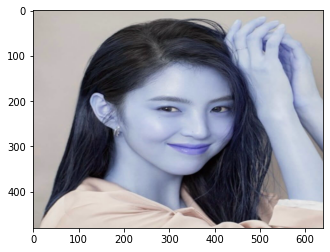

In [13]:
import os
import cv2
import matplotlib.pyplot as plt
# my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
my_image_path = './images/hansohee.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv에서 이미지 읽기 flag는 아래와 같이 3가지가 있으며 순서대로 1, 0, -1의 값을 갖습니다.  

`cv2.IMREAD_COLOR` : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.  

`cv2.IMREAD_GRAYSCALE` : 이미지를 Grayscale로 읽어들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.  

`cv2.IMREAD_UNCHANGED` : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.  

`cv2.imread('img.png', 0)`이라고 호출했다면 이미지를 Grayscale로 읽어들인다는 뜻입니다.  




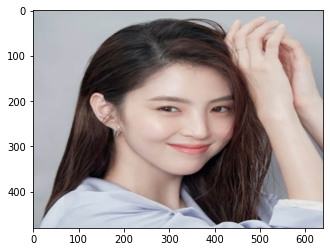

In [14]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 (Face Detection)

dlib의 face detector는 HOG(Histogram of Oriented Gradients) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다.  

자세한 알고리즘은 아래 링크를 참고하세요.  
[딥러닝을 사용한 Face Recognition](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)

관련 패키지 설치
```python
pip install opencv-python
pip install cmake
pip install dlib
```



rectangles[[(241, 142) (464, 365)]]


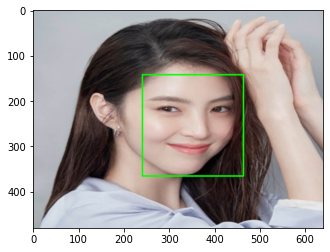

In [15]:
# hog detector 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# 찾은 얼굴영역 출력
print(dlib_rects)    # 찾은 얼굴영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 얼굴 랜드마크 (Face Landmark)

잘라진 얼굴 이미지에서 아래 68개의 이목구비를 찾습니다.  
이때 점의 개수는 데이터셋과 논문마다 다릅니다.  
![priority landmark](https://user-images.githubusercontent.com/48689553/136308463-3a227396-df02-4dd5-becb-0982d770ec87.JPG)  

Dlib은 ibug [300-W 데이터셋](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)으로 학습한 pretrained model을 제공합니다.  
학습 알고리즘은 regression tree의 앙상블 모델을 사용했습니다.  
자세한 내용은 **2014 CVPR**에서 발표한 **One Millisecond Face Alignment with an Ensemble of Regression Trees**을 참고해주세요.  
- [One Millisecond Face Alignment with an Ensemble of Regression Trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)

여기서는 Dlib의 제공되는 모델을 사용하겠습니다.  
```
wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2
```

In [21]:
# landmark 모델 불러오기
import os
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


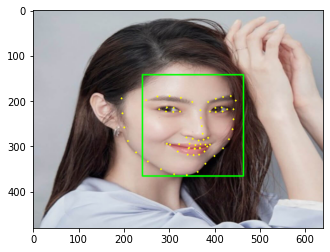

In [22]:
# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)    # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기

얼굴 위치, 카메라의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산해야 합니다.  
1. 스티커 위치
$$ x = x_{nose} $$

$$ y = y_{nose} - \frac{width}{2} $$

2. 스티커 크기
$$ width = height = width_{bbox} $$

In [20]:
# 좌표 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])    # nose center index: 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x, y) : (%d, %d)' % (x, y))
    print('(w, h) : (%d, %d)' % (w, h))
    

(374, 272)
(x, y) : (374, 160)
(w, h) : (224, 224)


왕관 이미지를 읽고 윗 단계에서 계산한 크기로 resize 합니다.

In [23]:
# 스티커 이미지 Read
import os
sticker_path = './images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
print(img_sticker.shape)

(224, 224, 3)


In [24]:
refined_x = x - w//2    # left
refined_y = y - h       # top
print(f'(x, y) : ({refined_x}, {refined_y})')

(x, y) : (262, -64)


opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다.  
ndarray는 음수 인덱스에 접근할 수 없기 때문에 예외 처리를 해야합니다.  
![error](https://user-images.githubusercontent.com/48689553/136311261-0e89d0d3-e1d6-4f6e-830d-d760f5bf9ba7.JPG)

In [25]:
# -y 크기만큼 스티커를 crop 합니다.
img_sticker = img_sticker[-refined_y:]
print(img_sticker.shape)

(160, 224, 3)


In [26]:
# top의 y 좌표는 원본 이미지의 경계 값으로 수정합니다.
refined_y = 0
print(f'(x, y): ({refined_x}, {refined_y})')

(x, y): (262, 0)


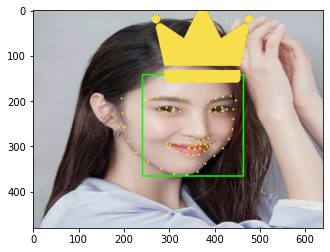

In [33]:
import numpy as np
# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = (
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8))

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

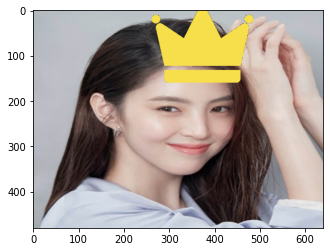

In [34]:
# bounding box 제거 후 이미지 출력
sticker_area = img_bgr[refined_y:img_sticker.shape[0],
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = (
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 미니 프로젝트 : 고양이 수염 스티커 만들기

## 0. 모듈 불러오기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 1. 사진 불러오기

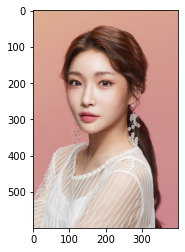

In [59]:
image_path = './images/chungha.jpg'
img_bgr = cv2.imread(image_path)    # opencv로 image read
img_show = img_bgr.copy()    # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # bgr -> rgb
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 (Face Detection)

rectangles[[(56, 139) (242, 325)]]


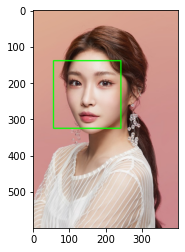

In [60]:
# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)

# detect한 얼굴 영역 좌표
print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


## 3. 랜드마크 추출 (Face Landmark)

In [61]:
# landmark model 불러오기
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
# landmark 갯수 확인
print(len(list_landmarks[0]))

68


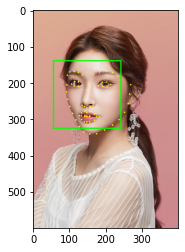

In [62]:
# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [63]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(145, 251)
(x,y) : (145,251)
(w,h) : (187,187)


## 4. 스티커 불러오기

(187, 187, 3)


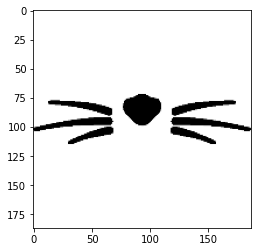

In [64]:
# 스티커 이미지 Read
sticker_path = './images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

In [65]:
# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (52,158)


In [66]:
# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(187, 187, 3)
(x,y) : (52,158)


## 5. 스티커 적용

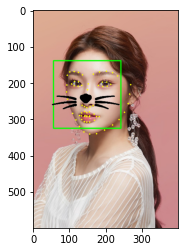

In [67]:
# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0],
         refined_x:refined_x+img_sticker.shape[1]] = (
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8))

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 6. 최종 출력

자연스러움을 위해 `cv2.addWeighted`를 적용했습니다.  

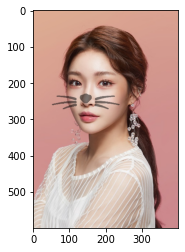

In [68]:
# 불투명도 조절
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0],
                            refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0],
        refined_x:refined_x+img_sticker.shape[1]] = (
    cv2.addWeighted(sticker_area, 0.5,
                    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8),
                    0.5, 0))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 고찰

얼굴을 잘 인식하고 수염까지 붙이는것을 완료하였습니다.  
시간이 부족해 아래의 예상되는 문제를 직접 확인해보진 못했지만  
Image를 다룰 때 대표적으로 거론되는 문제를 통해 발생할 수 있는 경우의 수를 예측할 수 있습니다.  
  

**예상되는 문제**  
- Viewpoint variation
  - 사용하는 face 라이브러리 dlib에서 정면에 대한 face detector만 불러옵니다.  
  - `detector_hog = dlib.get_frontal_face_detector()`  
  - Viewpoint가 바뀌는 경우 -> 우(좌)측면, bird view 등에서는 성능이 떨어집니다.  

- Illumination
  - 밝기변화에 의해 성능이 떨어질 수 있습니다.  
  - ex) 밤/낮, 조명의 밝기
- Occulsion
  - 얼굴을 가리는 경우 문제가 될 수 있습니다.  
- Background Clutter
  - 배경과 face가 거의 비슷하게 생기는 경우 문제가 발생할 수 있습니다.  

